In [0]:
##Loading all the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [0]:
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=transforms
        )

test_dataset = datasets.MNIST(
        './data',
        train=False,
        download=True,
        transform=transforms
    )

In [0]:
BATCH_SIZE = 100     
N_EPOCHS = 50      
INPUT_DIM = 28 * 28 
HIDDEN_DIM = 512
#Introduction of another linear layer to increase performance
HIDDEN_DIM_2=256 
LATENT_DIM = 2
lr = 1e-3           

In [0]:
##Instantiate the  iterator objects for the train ans the test dataset
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)


**CREATING THE ENCODER ARCHITECTURE**


In [0]:
class Encoder(nn.Module):
  def __init__(self,input_dim,hidden_dim,hidden_dim_2,z_dim):#Z_dim is the dimensionality of the latent space
    super().__init__()
    self.linear=nn.Linear(input_dim,hidden_dim)
    self.linear_2=nn.Linear(hidden_dim,hidden_dim_2)#Second hidden layer 
    self.mean=nn.Linear(hidden_dim_2,z_dim)#This layer trains the mean_parameter of the latent space  distribution
    self.variance=nn.Linear(hidden_dim_2,z_dim)#This layer trains the variance parameter of the distribution
  def forward(self,x):
    #x is of the shape [batch_size,input_dim]
    hidden=F.relu(self.linear(x))
    hidden_2=F.relu(self.linear_2(hidden))
    z_mean=self.mean(hidden_2)#z_mean and z_variance have the shape [hidden_dim,latent_space_dim]
    z_variance=self.variance(hidden_2)
    return z_mean,z_variance

**CREATING THE DECODER ARHITECTURE**


In [0]:
class Decoder(nn.Module):
  def __init__(self,z_dim,hidden_dim_2,hidden_dim,output_dim):
    ##The basic aim here is take input from the latent dimension create an intermaediate trainable layer and output it to the original dimension of the figure i.e 28*28
    super().__init__()
    self.linear=nn.Linear(z_dim,hidden_dim_2)
    self.linear_2=nn.Linear(hidden_dim_2,hidden_dim)
    self.out=nn.Linear(hidden_dim,output_dim)
  def forward(self,x):
    hidden=F.relu(self.linear(x))
    hidden_2=F.relu(self.linear_2(hidden))
    predicted=torch.sigmoid(self.out(hidden_2))
    return predicted


**COMBINING THE ENCODER AND THE DECODER**

In [0]:
class VAEncoder(nn.Module):
  def __init__(self,encoder,decoder):
    super().__init__()
    self.enc=encoder
    self.dec=decoder
  def forward(self,x):
    #The outputs from the encoder z_mean and z_variance
    z_mean,z_variance=self.enc(x)
    #Sample from the distribution having latent parameters z_mean and z_variance
    std=torch.exp(z_mean/2)
    eps=torch.randn_like(std)
    x_sample=eps.mul(std).add(z_mean)
    ##Get the preditions
    predicted=self.dec(x_sample)
    return predicted,z_mean,z_variance



**INSTANTIAtING THE NETWORK**




In [0]:
 # encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM,HIDDEN_DIM_2, LATENT_DIM)

    # decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM_2,HIDDEN_DIM, INPUT_DIM)

    # vae
model = VAEncoder(encoder, decoder).to(device)

    # optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [0]:
def train():
        # set the train mode
        model.train()

        # loss of the epoch
        train_loss = 0

        for i, (x, _) in enumerate(train_iterator):
            # reshape the data into [batch_size, 784]
            x = x.view(-1, 28 * 28)
            x = x.to(device)
            
            # update the gradients to zero
            optimizer.zero_grad()

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, reduction='sum')

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss

            # backward pass
            loss.backward()
            train_loss += loss.item()
            
            # update the weights
            optimizer.step()

        return train_loss



def test():
        # set the evaluation mode
        model.eval()

        # test loss for the data
        test_loss = 0

        # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
        with torch.no_grad():
            for i, (x, _) in enumerate(test_iterator):
                # reshape the data
                x = x.view(-1, 28 * 28)
                x = x.to(device)

                # forward pass
                x_sample, z_mu, z_var = model(x)

                # reconstruction loss
                recon_loss = F.binary_cross_entropy(x_sample, x, reduction='sum')
                
                # kl divergence loss
                kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
                
                # total loss
                loss = recon_loss + kl_loss
                test_loss += loss.item()

        return test_loss



Epoch 0, Train Loss: 173.67, Test Loss: 172.02
Epoch 1, Train Loss: 170.26, Test Loss: 170.01
Epoch 2, Train Loss: 168.08, Test Loss: 167.16
Epoch 3, Train Loss: 166.37, Test Loss: 165.96
Epoch 4, Train Loss: 165.34, Test Loss: 165.07
Epoch 5, Train Loss: 164.58, Test Loss: 164.20
Epoch 6, Train Loss: 163.75, Test Loss: 163.81
Epoch 7, Train Loss: 162.98, Test Loss: 163.02
Epoch 8, Train Loss: 162.50, Test Loss: 162.09
Epoch 9, Train Loss: 161.82, Test Loss: 162.34
Epoch 10, Train Loss: 161.64, Test Loss: 162.27
Epoch 11, Train Loss: 161.08, Test Loss: 161.36
Epoch 12, Train Loss: 160.74, Test Loss: 161.29
Epoch 13, Train Loss: 160.31, Test Loss: 160.74
Epoch 14, Train Loss: 160.20, Test Loss: 160.36
Epoch 15, Train Loss: 159.99, Test Loss: 160.17
Epoch 16, Train Loss: 159.73, Test Loss: 160.29
Epoch 17, Train Loss: 159.48, Test Loss: 160.22
Epoch 18, Train Loss: 159.28, Test Loss: 159.70
Epoch 19, Train Loss: 159.15, Test Loss: 159.27
Epoch 20, Train Loss: 158.93, Test Loss: 159.02
Ep

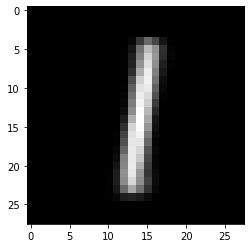

In [120]:
best_test_loss = float('inf')

for e in range(N_EPOCHS):

        train_loss = train()
        test_loss = test()

        train_loss /= len(train_dataset)
        test_loss /= len(test_dataset)

        print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

        if best_test_loss > test_loss:
            best_test_loss = test_loss
            patience_counter = 1
        else:
            patience_counter += 1

        if patience_counter > 5:
            break
        for g in range(10):
          z = torch.randn(1, LATENT_DIM).to(device)

           # run only the decoder
          reconstructed_img = model.dec(z)
          img = reconstructed_img.view(28, 28).data


          plt.imshow(img.cpu().numpy(), cmap='gray')

In [123]:
from torchvision.utils import save_image

 # sample and generate a image
with torch.no_grad(): 
      z = torch.randn(64, LATENT_DIM).to(device)

      # run only the decoder
      reconstructed_img = model.dec(z)
      img = reconstructed_img.view(64,1,28, 28).data

      print(z.shape)
      print(img.shape)

      
      save_image(img, 'sample_' + '.png')

torch.Size([64, 2])
torch.Size([64, 1, 28, 28])


In [103]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = VAEncoder.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), 'sample_' + '.png')

AttributeError: ignored